AI hallucinations and the fastMRI challenge - a brief report on what did not work and what did work so far.

The fastMRI challenge is a collaborative research project from Facebook AI Research (FAIR) and NYU Langone Health to investigate the use of AI to make Magnetic Resonance Imaging (MRI) scans faster. MRI scans are typically slow and expensive, as state of the art methods such as Compressive Sensing require an amount of measurements that makes scan times long. However, AI provides means to reconstruct realistic looking images using far less measurements and, hence, reduce scan times and medical costs. However, there may be pitfalls when using deep learning models in image reconstruction, such as so coined AI generated hallucinations. These can be described as a small detail appearing in the reconstructed image, which is not appearent in the ground truth.

"The most serious issue when applying deep learning for discovery is that of hallucination. [...] These hallucinations are deceptive artifacts that appear highly plausible in the absence of contradictory information and can be challenging, if not impossible, to detect." From "Applications, promises, and pitfalls of deep learning for fluorescence image reconstruction", Nature Methods, 2019.

The aim of this project is to investigate pre-trained neural networks provided by the fastMRI challenge on the risk of AI hallucinations. Based on the code provided by the authors of "On Hallucinations in Tomographic Image Reconstruction", IEEE 2021, we want to extend their code for computing measurement and null space hallucination maps from measurement data, a measurement matrix H, a ground truth and reconstructed image. The code is specific to tomographic image reconstruction and we aim at extending it to measurements and ground truths provided by a measurement matrix of for a multicoil MRI apparatus. This project is not finished yet, as its scope and the computational time required for experiments is outside of the time given five weeks. 

In the following the methods aimed to use for this project and code, so far it is available, will be described. In particular, issues, as to why it is not finished yet are the following:
- the MRI images, given in h5 files, are too large for my current Laptop to handle and I will need to work with other collaborators in order to complete the computations.
- the pretrained networks, in particular the varnet, still seem to have a problem with the evaluation code. The checkpoints and files can be loaded, however, there is an issue with the file containing the coil positions. Currently, I am trying to resolve this.


Prior to using models provided by the fastMRI challenge, there are instructions on what to install on https://github.com/facebookresearch/fastMRI . In order to use to pretrained varnet, we need to install the same version of pytorch and python (https://github.com/facebookresearch/fastMRI/blob/main/setup.cfg) they used:

In [ ]:
pip install pytorch-lightning 

In [ ]:
pip install fastmri

In [ ]:
pip install -r fastmri_examples/adaptive_varnet/requirements.txt

After this a pretrained model, a varnet and unet, will be used with downloaded checkpoints. The evaluation command for the varned is:

In [ ]:
python ./fastmri_examples/adaptive_varnet/eval_pretrained_adaptive_varnet.py --load_checkpoint C:\Users\ASUS\fastMRI\ModelCheckpoints\adaptive_4x.ckpt  --data_path C:\Users\ASUS\fastMRI\Dataeval\knee_singlecoil_test_v2.tar\singlecoil_test_v2 --challenge multicoil --batch_size 64 --accelerations 4 --center_fractions 0.08

And for the unet which can be used on single coil MRI data:

In [ ]:
 python run_pretrained_varnet_inference.py \
    --data_path C:\Users\ASUS\fastMRI\Dataeval\brainmultitest\brain_multicoil_test\multicoil_test \
    --output_path C:\Users\ASUS\fastMRI\Outputs \
    --challenge varnet_brain_mc

In order to evaluate the pretrained models, the output data needs to be assessed visually. This can be done via the following code, assuming one goes to the folder where the output images are stored:

In [8]:
cd fastMRI

C:\Users\ASUS\fastMRI


In [9]:
%matplotlib inline
#import necessary programmes for visualising and opening files.
import h5py
import numpy as np
from matplotlib import pyplot as plt

In [13]:
cd Dataeval

C:\Users\ASUS\fastMRI\Dataeval


In [16]:
cd brainmultitest

C:\Users\ASUS\fastMRI\Dataeval\brainmultitest


In [17]:
cd brain_multicoil_test

C:\Users\ASUS\fastMRI\Dataeval\brainmultitest\brain_multicoil_test


In [18]:
cd multicoil_test

C:\Users\ASUS\fastMRI\Dataeval\brainmultitest\brain_multicoil_test\multicoil_test


The following is concerned with opening, renaming, and visualising the content of a specific hdf5 file containing two tensors:
- kspace: Undersampled multi-coil k-space. The shape of the kspace tensor is (number of slices, number of coils, height, width).
- mask: Defines the undersampled Cartesian k-space trajectory. The number of elements in the mask tensor is the same as the width of k-space.

The instructions for the following code are given on the github directory of the fastMRI challenge.

In [20]:
file_name = 'file_brain_AXT2_200_2000046.h5' #a sepecific file containing a groundtruth,
hf = h5py.File(file_name)

In [21]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 4, 'acquisition': 'AXT2', 'num_low_frequency': 32, 'patient_id': 'a8eb076a0feabdb84c74a8ab12e70ef66aa73a173218c853b6c88da351209068'}


In [22]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 16, 768, 396)


In [25]:
slice_kspace = volume_kspace[2] # Choosing the 2nd slice of this volume



In [26]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

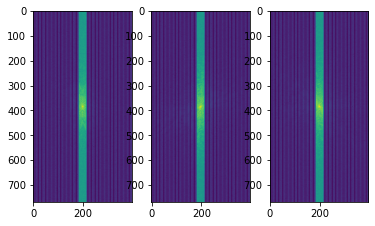

In [27]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10



In [28]:
import fastmri
from fastmri.data import transforms as T

In [29]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

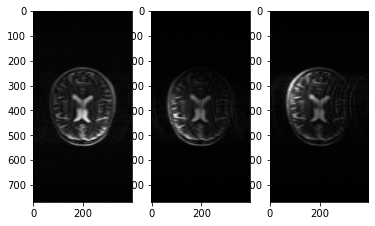

In [30]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray') #



In [31]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)



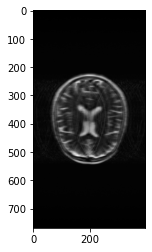

In [33]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray');

In [34]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [35]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

In [36]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

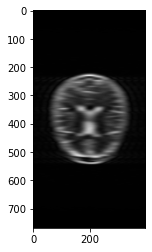

In [38]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray');

